In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load From Excel: Slow
df=pd.read_csv('train.csv')
X=np.zeros((len(df),48,48,1))
y = df.emotion.values

for i in range(len(df)):
    x = df.iloc[i]['pixels']
    x = x.split()
    x = [int(i) for i in x]
    x = np.array(x)
    x = x.reshape(48,48).astype('float32')
    X[i,:,:,0] = x

with open('emotion_dataset.npy', 'wb') as f:
    np.save(f, X)
    np.save(f, y)

In [6]:
# Load from npy: Fast:
with open('emotion_dataset.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

In [7]:
num_classes = len(np.unique(y))

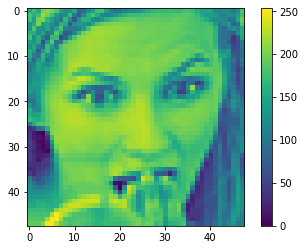

In [8]:
i = np.random.randint(X.shape[0])
plt.imshow(X[i,:,:,0])
plt.colorbar()
plt.show()

In [9]:
print(X.shape)

(28709, 48, 48, 1)


In [10]:
print(y.shape)

(28709,)


In [11]:
import tensorflow as tf

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [13]:
ds_train = tf.data.Dataset.from_tensor_slices(
   (X_train,y_train)) 
ds_test = tf.data.Dataset.from_tensor_slices(
   (X_test,y_test))

ds_train.element_spec

(TensorSpec(shape=(48, 48, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
BUFFER_SIZE = 500
BATCH_SIZE = 50
ds_train = ds_train.shuffle(BUFFER_SIZE)
ds_train = ds_train.batch(BATCH_SIZE)
ds_test = ds_test.batch(BATCH_SIZE)

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [17]:
normalized_ds = ds_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0.050980397 0.7607844


In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(48, 
                                                              48,
                                                              1)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

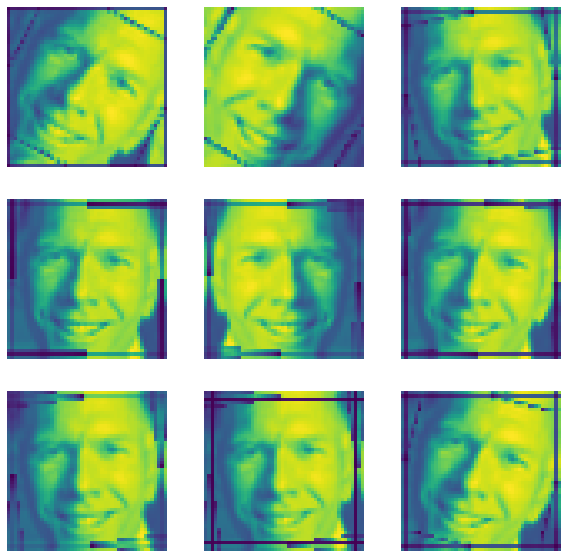

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in ds_train.take(1):
      for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy()[:,:,0])
            plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 48, 48, 1)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)       

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
for x,y in ds_train.take(1):
    pass

In [25]:
x.shape

TensorShape([50, 48, 48, 1])

In [26]:
epochs=100
history = model.fit(
  ds_train,
  validation_data=ds_test,
  epochs=epochs
)

Epoch 1/100
385/385 [==============================] - 4s 10ms/step - loss: 1.7974 - accuracy: 0.2563 - val_loss: 1.7410 - val_accuracy: 0.2818
Epoch 2/100
385/385 [==============================] - 3s 9ms/step - loss: 1.7290 - accuracy: 0.2949 - val_loss: 1.6458 - val_accuracy: 0.3479
Epoch 3/100
385/385 [==============================] - 3s 9ms/step - loss: 1.6714 - accuracy: 0.3388 - val_loss: 1.5798 - val_accuracy: 0.3772
Epoch 4/100
385/385 [==============================] - 3s 9ms/step - loss: 1.6265 - accuracy: 0.3625 - val_loss: 1.5370 - val_accuracy: 0.3985
Epoch 5/100
385/385 [==============================] - 3s 9ms/step - loss: 1.5918 - accuracy: 0.3781 - val_loss: 1.4929 - val_accuracy: 0.4276
Epoch 6/100
385/385 [==============================] - 3s 9ms/step - loss: 1.5614 - accuracy: 0.3954 - val_loss: 1.4924 - val_accuracy: 0.4218
Epoch 7/100
385/385 [==============================] - 3s 9ms/step - loss: 1.5260 - accuracy: 0.4058 - val_loss: 1.4300 - val_accuracy: 0.449

Epoch 58/100
385/385 [==============================] - 3s 9ms/step - loss: 1.2086 - accuracy: 0.5405 - val_loss: 1.2003 - val_accuracy: 0.5423
Epoch 59/100
385/385 [==============================] - 3s 9ms/step - loss: 1.2127 - accuracy: 0.5400 - val_loss: 1.1651 - val_accuracy: 0.5586
Epoch 60/100
385/385 [==============================] - 3s 9ms/step - loss: 1.2074 - accuracy: 0.5401 - val_loss: 1.1624 - val_accuracy: 0.5602
Epoch 61/100
385/385 [==============================] - 3s 9ms/step - loss: 1.2006 - accuracy: 0.5409 - val_loss: 1.1525 - val_accuracy: 0.5608
Epoch 62/100
385/385 [==============================] - 3s 9ms/step - loss: 1.1975 - accuracy: 0.5421 - val_loss: 1.1629 - val_accuracy: 0.5564
Epoch 63/100
385/385 [==============================] - 3s 9ms/step - loss: 1.2014 - accuracy: 0.5407 - val_loss: 1.1748 - val_accuracy: 0.5507
Epoch 64/100
385/385 [==============================] - 3s 8ms/step - loss: 1.1940 - accuracy: 0.5415 - val_loss: 1.1488 - val_accuracy:

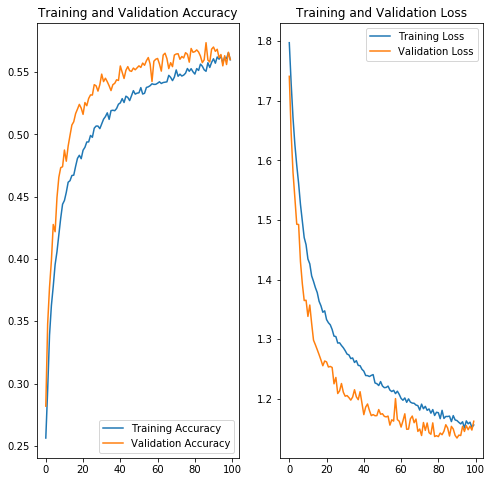

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()